In [538]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anmolkumar/health-insurance-cross-sell-prediction")

print("Path to dataset files:", path)

Path to dataset files: /Users/jeongho/.cache/kagglehub/datasets/anmolkumar/health-insurance-cross-sell-prediction/versions/1


In [539]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [540]:
train_df = pd.read_csv(os.path.join(path, "train.csv"))
test_df = pd.read_csv(os.path.join(path, "test.csv"))
sample_submission = pd.read_csv(os.path.join(path, "sample_submission.csv"))

In [541]:
print(test_df.shape)
print(train_df.shape)

(127037, 11)
(381109, 12)


In [542]:
df = pd.concat([test_df, train_df], axis=0)

In [543]:
def binary_encode(df, column, postive_label):
    df = df.copy()
    df.apply(lambda x: 1 if x == postive_label else 0)
    return df


def ordinal_encode(df, column, ordering):
    df = df.copy()
    df[column] = df[column].apply(lambda x: ordering.index(x))
    return df


def onehot_encode(df, column):
    dummies = pd.get_dummies(df[column])
    df = df.concat([dummies, df], axis=1)
    df = df.drop(column, axis=1)
    return df

In [544]:
cat_cols = list(df.select_dtypes("object").columns)

In [545]:
dict = {}

for col in cat_cols:
    dict[col] = {col: list(train_df[col].unique())}

print(dict)

{'Gender': {'Gender': ['Male', 'Female']}, 'Vehicle_Age': {'Vehicle_Age': ['> 2 Years', '1-2 Year', '< 1 Year']}, 'Vehicle_Damage': {'Vehicle_Damage': ['Yes', 'No']}}


In [546]:
def preprocess_input(df):

    df = df.copy()
    # nominal feature
    df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0})
    df["Vehicle_Age"] = df["Vehicle_Age"].map(
        {"> 2 Years": 2, "1-2 Year": 1, "< 1 Year": 0}
    )
    df["Vehicle_Damage"] = df["Vehicle_Damage"].map({"Yes": 1, "No": 0})

    test_df = df.iloc[:127037]

    test_ids = list(test_df["id"].iloc[:127037])

    df = df.drop(["id"], axis=1)

    test_df = df.iloc[:127037]
    train_df = df.iloc[127037:]

    y = train_df["Response"]
    X = train_df.drop(["Response"], axis=1)
    test_df = test_df.drop(["Response"], axis=1)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    test_scaled = scaler.fit_transform(test_df)

    X = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    test_df = pd.DataFrame(test_scaled, columns=test_df.columns, index=test_df.index)

    return X, y, test_df, test_ids

In [547]:
X, y, test_df, test_ids = preprocess_input(df)

In [548]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [549]:
y.sum() / len(y)

0.12256336113815208

In [550]:
# X.plot(kind = 'box', figsize=(10, 10),  logy=True)
X.shape

(381109, 10)

In [551]:
inputs = tf.keras.Input(shape=(10,))  # X.shape 10 features
x = tf.keras.layers.Dense(64, activation="relu")(inputs)
x = tf.keras.layers.Dense(64, activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="auc")],
)

batch_size = 64
epochs = 25

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()],
    verbose=0,
)

In [552]:
import plotly.express as px

fig = px.line(
    history.history,
    y=["loss", "val_loss"],
    labels={"index": "Epoch", "value": "Loss"},
    title="Training History",
)
fig.show()

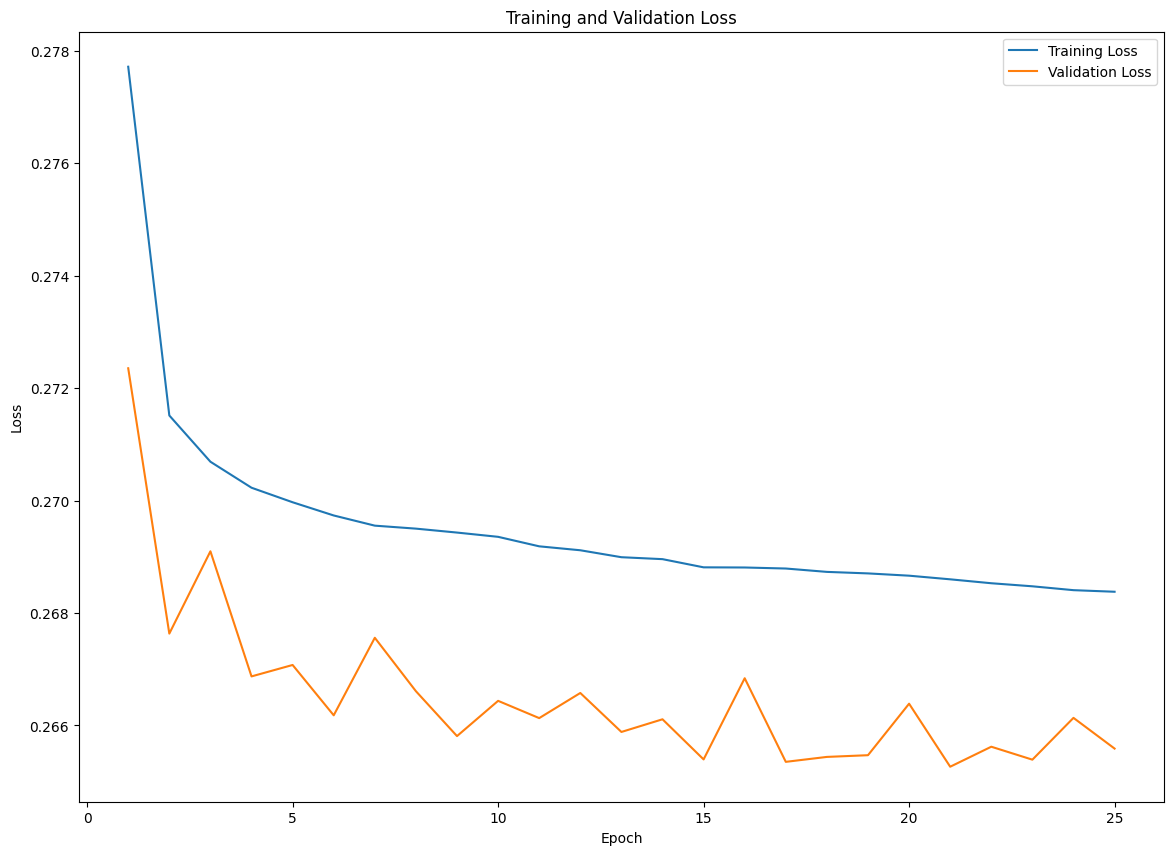

In [553]:
plt.figure(figsize=(14, 10))
epochs_range = range(1, epochs + 1)
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [554]:
np.argmin(val_loss)

20

In [555]:
model.evaluate(X_test, y_test)

3573/3573 ━━━━━━━━━━━━━━━━━━━━ 2s 578us/step - auc: 0.8529 - loss: 0.2685


[0.26833873987197876, 0.8527363538742065]

In [556]:
preds = model.predict(test_df)

   1/3970 ━━━━━━━━━━━━━━━━━━━━ 1:47 27ms/step

3970/3970 ━━━━━━━━━━━━━━━━━━━━ 1s 307us/step


In [557]:
preds

array([[8.3298240e-05],
       [2.7377096e-01],
       [2.9221359e-01],
       ...,
       [9.5657604e-05],
       [2.0201905e-05],
       [5.1094493e-04]], dtype=float32)

In [558]:
preds >= 0.5

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [559]:
preds = list(map(lambda x: int(x[0]), preds >= 0.5))

test_ids

[381110,
 381111,
 381112,
 381113,
 381114,
 381115,
 381116,
 381117,
 381118,
 381119,
 381120,
 381121,
 381122,
 381123,
 381124,
 381125,
 381126,
 381127,
 381128,
 381129,
 381130,
 381131,
 381132,
 381133,
 381134,
 381135,
 381136,
 381137,
 381138,
 381139,
 381140,
 381141,
 381142,
 381143,
 381144,
 381145,
 381146,
 381147,
 381148,
 381149,
 381150,
 381151,
 381152,
 381153,
 381154,
 381155,
 381156,
 381157,
 381158,
 381159,
 381160,
 381161,
 381162,
 381163,
 381164,
 381165,
 381166,
 381167,
 381168,
 381169,
 381170,
 381171,
 381172,
 381173,
 381174,
 381175,
 381176,
 381177,
 381178,
 381179,
 381180,
 381181,
 381182,
 381183,
 381184,
 381185,
 381186,
 381187,
 381188,
 381189,
 381190,
 381191,
 381192,
 381193,
 381194,
 381195,
 381196,
 381197,
 381198,
 381199,
 381200,
 381201,
 381202,
 381203,
 381204,
 381205,
 381206,
 381207,
 381208,
 381209,
 381210,
 381211,
 381212,
 381213,
 381214,
 381215,
 381216,
 381217,
 381218,
 381219,
 381220,
 

In [560]:
submission_df = pd.concat([pd.Series(test_ids), pd.Series(preds)], axis=1)
submission_columns = ["id", "Response"]

In [561]:
submission = pd.DataFrame(submission_df, columns=submission_columns)
submission

,id,Response
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
127032,NaN,NaN
127033,NaN,NaN
127034,NaN,NaN
127035,NaN,NaN


In [563]:
sample_submission.shape == submission.shape

True

In [564]:
submission.to_csv("./submission.csv")